In [1]:
from implicit_learning.trainer import PoissonTrainer 
from implicit_learning.model import  Siren
from implicit_learning.dataset import PoissonEqn
from implicit_learning.utils import *
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader 

import torch
import matplotlib.pyplot as plt 
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [2]:
def construct_dataloader(config):
    sidelength = config['sidelength']
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

    train = PoissonEqn(config, transform=transform)
    valid = PoissonEqn(config, transform=transform)
    test  = PoissonEqn(config, transform=transform)
    
    train_dataloader =  DataLoader(train, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    valid_datalodaer =  DataLoader(valid, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    test_dataloader =   DataLoader(test, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)

    return train_dataloader, valid_datalodaer, test_dataloader

class CustomizeTrainer(PoissonTrainer):
    def __init__(self, model, train_dataloader, valid_dataloader, test_dataloader, config, beta=0.8):
        self.lr = config.get("lr")
        super().__init__(model, train_dataloader, valid_dataloader, test_dataloader, config)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.print_epoch = config.get("print_epoch")
        self.sidelength = config.get("sidelength")

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                        lr_lambda=lambda epoch: 1/(1000+((epoch))),
                                        last_epoch=-1,
                                        verbose=False)
        self.beta = beta 

    def train(self):
        for epoch in range(self.epochs+1):
            inputs = self.model_input

            self.optimizer.zero_grad() 
            outputs, coords =self.model(inputs)
            grad_loss = self.compute_grad_loss(outputs, coords)
            value_loss = self.compute_value_loss(outputs, coords)
            self.loss = (1- self.beta) * grad_loss + self.beta * value_loss

            if epoch %  self.print_epoch == 0:
                print("")
                print("--- Epoch %5d/%d ---\n"%(epoch, self.epochs), f" Beta: {self.beta:.3f}", end=" | ")
                print("Loss: %.6f  value_loss: %.6f  grad_loss: %.6f"%(self.loss, value_loss.item(), grad_loss.item()))
                print("PSNR : %.3f | SSIM : %.3f | (GT-GT) PSNR : %.3f | (GT-GT) SSIM : %.3f  "\
                                                    %(self.detach_and_calculate_psnr(outputs, self.gt['pixels']), 
                                                      self.detach_and_calculate_ssim(outputs, self.gt['pixels']),
                                                      self.detach_and_calculate_psnr(self.gt['pixels'], self.gt['pixels']), 
                                                      self.detach_and_calculate_ssim(self.gt['pixels'], self.gt['pixels'])))
                img_grad = gradient(outputs, coords)
                self.plot(outputs, self.gt['pixels'], img_grad, self.gt)

            self.loss.backward()
            self.optimizer.step()
            self.scheduler.step()

    def compute_grad_loss(self, outputs, coords):
        train_loss = self.gradients_mse(outputs, coords, self.gt['grads'])
        return train_loss 

    def compute_value_loss(self, outputs, coords):
        train_loss = ((outputs - self.gt['pixels'])**2).mean()
        return train_loss

    def set_beta(self, beta):
        self.beta = beta 

    def gradients_mse(self, model_output, coords, gt_gradients):
        gradients = gradient(model_output, coords)
        gradients_loss = torch.mean((gradients - gt_gradients).pow(2).sum(-1))
        return gradients_loss

    def detach_and_calculate_psnr(self, model_output, ground_truth):
        model_output = model_output.view(self.sidelength, self.sidelength).detach().cpu().numpy()
        ground_truth = ground_truth.view(self.sidelength, self.sidelength).detach().cpu().numpy()
        return calculate_psnr(model_output, ground_truth)

    def detach_and_calculate_ssim(self, model_output, ground_truth):
        model_output = model_output.view(self.sidelength, self.sidelength).detach().cpu().numpy()
        ground_truth = ground_truth.view(self.sidelength, self.sidelength).detach().cpu().numpy()
        return calculate_ssim(model_output, ground_truth) 

    def plot(self, model_output, original, img_grad, gt):
        # --- image plot
        fig, axes = plt.subplots(1, 4, figsize=(10, 5))
        axes[0].imshow(model_output.cpu().view(self.sidelength,self.sidelength).detach().numpy())
        axes[1].imshow(original.cpu().view(self.sidelength,self.sidelength).detach().numpy())
        axes[2].imshow(img_grad.cpu().norm(dim=-1).view(self.sidelength,self.sidelength).detach().numpy())
        axes[3].imshow(gt['grads'].cpu().norm(dim=-1).view(self.sidelength,self.sidelength).detach().numpy())
        axes[0].set_title("Pred values")
        axes[1].set_title("GT values")
        axes[2].set_title("Pred grads")
        axes[3].set_title("GT grads")
        
        # --- histogram 
        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
        axes[0].hist(model_output.flatten().cpu().detach().numpy(), bins=200,log=True)
        axes[0].hist(gt['pixels'].flatten().cpu().detach().numpy(), bins=200,log=True)
        axes[0].legend(["model", "ground truth"])
        axes[0].set_title("value histogram")
        axes[1].hist(img_grad.view(1, self.sidelength, self.sidelength,2)[:,:,:,0].flatten().cpu().detach().numpy(), bins=200,log=True)
        axes[1].hist(gt['grads'].view(1, self.sidelength, self.sidelength,2)[:,:,:,0].flatten().cpu().detach().numpy(), bins=200,log=True)
        axes[1].legend(["model", "ground truth"])
        axes[1].set_title("grad histogram")
        plt.tight_layout()
        plt.show()


--- Epoch     0/100 ---
  Beta: 0.990 | Loss: 1.776955  value_loss: 1.369973  grad_loss: 42.068199
PSNR : 46.764 | SSIM : -0.297 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


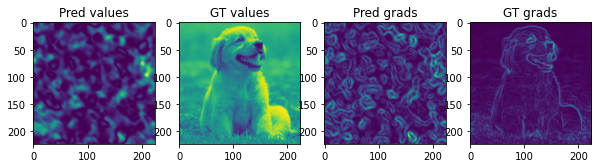

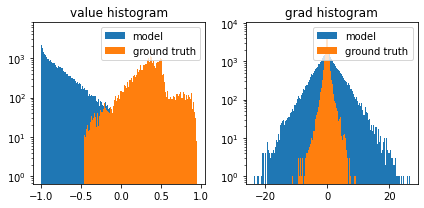


--- Epoch   100/100 ---
  Beta: 0.990 | Loss: 0.024144  value_loss: 0.008731  grad_loss: 1.550048
PSNR : 68.720 | SSIM : 0.699 | (GT-GT) PSNR : inf | (GT-GT) SSIM : 1.000  


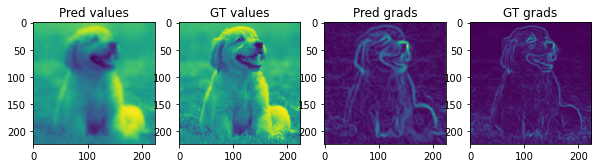

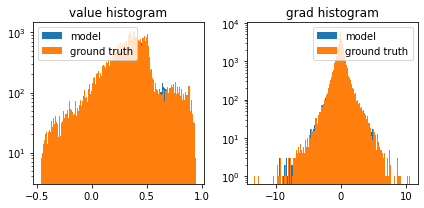

In [3]:

config = {
    "model":{
        "in_features":2,
        "hidden_features":80,
        "hidden_layers":5,
        "out_features":1
    },
    "sidelength":224,
    "epochs":100,
    "lr":0.1,
    "batch_size":1,
    "data-path":"../../data/dog224.png",
    "print_epoch":100
}

model = Siren(**config['model'])
model.cuda()
trainer = CustomizeTrainer(model, *construct_dataloader(config), config, beta=0.99)

trainer.train()

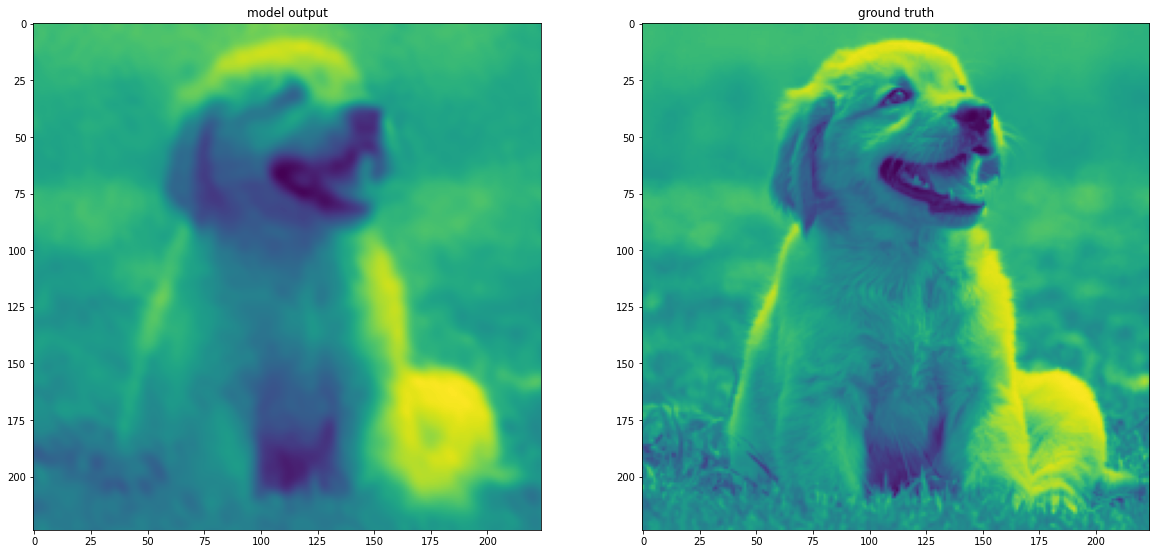

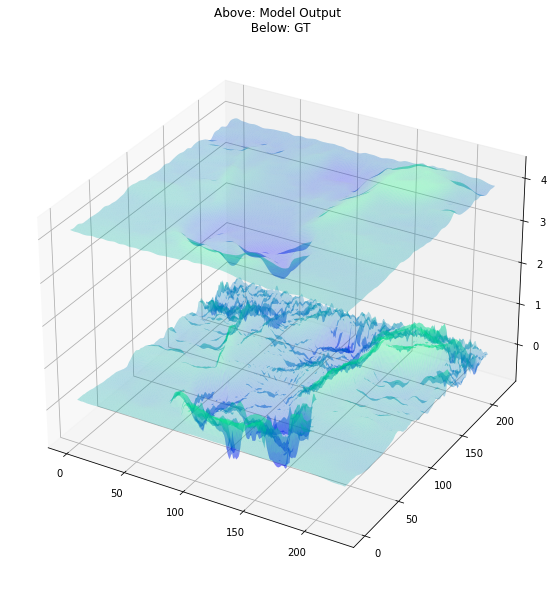

In [4]:
model_input = trainer.model_input 
fig, ax = plt.subplots(1,2, figsize=(20,15))

image = trainer.model.forward(model_input)[0].detach().cpu().numpy().reshape(config.get("sidelength"),config.get("sidelength"))
truth  = trainer.gt['pixels'].detach().cpu().numpy().reshape(config.get("sidelength"),config.get("sidelength"))

ax[0].imshow(image)
ax[1].imshow(truth)

ax[0].set_title("model output")
ax[1].set_title("ground truth")

# Surface plot 
image = image - image.mean() +4
truth = truth - truth.mean()

x, y = np.meshgrid(range(config.get("sidelength")), range(config.get("sidelength")))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d', )
ax.plot_surface(x,y, truth, rstride=1, cstride=1,
                cmap='winter', edgecolor='none', alpha=0.3)

ax.plot_surface(x,y, image, rstride=1, cstride=1,
                cmap='winter', edgecolor='none', alpha=0.3)

ax.set_title("Above: Model Output \n Below: GT")
plt.show()